# POPPY Simulation: MagAO-X Surface Check (Master file)
## Notes: 
- This file has aberrations present due to PSDs on the optical surfaces.
- This version uses a CSV file to make an easier time to analyze the diffraction effect initiated by each optical surface and to allow for optical system changes. The CSV file can be found here: https://github.com/jlumbres/magaox_poppy/blob/master/data/rx_magaox.csv
- The function definitions used in this file may be found here: https://github.com/jlumbres/magaox_poppy/blob/master/magaoxFunctions.py
- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.
- The FITS files generated in code are not included in github, but can be calculated by running this code.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
import magaoxFunctions as mf

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file. All MagAO-X elements (after F/11 focal plane) have their distances pulled from the Zemax file's Merit Function Editor (using RAG command)

### Optical elements not implemented:
- ADC1
- ADC2
- 9mm Lyot Stop

### To-do Tasks:
- Revisiting the Lyot phase low pass filtering
- Investigate flux inside small region of dark hole to see which optic creates most change
- Create separate modules file for cleaner code running (there's a lot of redundancy present)

## Task 0: CSV Prescription Load

The system is stored as a CSV file describing each optics prescription and the distance between them. The CSV file also contains the surface map PSD files for each optical surface. At each F/number focal plane, the correction value has already been implemented, as defined from a previous file build.

In [2]:
rx_sys_file = 'data/rx_magaox.csv'
rx_sys=np.genfromtxt(rx_sys_file, delimiter=',', 
                  dtype="i2,U19,U10,f8,f8,f8,U90,U10,U10,f8,U10,",
                  skip_header=15,names=True)
print("The names of the headers are:")
print(rx_sys.dtype.names)

The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')


The following data is applied for every optical system build.

In [3]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution
beam_ratio = 0.34 # PROPER definition that has held for whole sim

Build the array that only calls for the mirrors (only the mirrors have the surfaces to examine)

In [4]:
mirrors_array = [] # start with an empty array
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Type'] == 'mirror':
        mirrors_array.append(test_opt['Optical_Element_Number'])
    elif test_opt['Name'] == 'Tweeter':
        tweeter_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']
    if test_opt['Name'] == 'M1':
        M1_num = test_opt['Optical_Element_Number']

#telescope = mirrors_array
telescope=[1,2,3] # testing just first 3 optics

# TESTING CODE IN THIS SECTION
Trying to rewrite the whole process into a single for-loop using function definitions. The multiple for-loop setup was much safer and showed that the logic flow is correct. However, these were difficult to navigate and change easily. So, I'm moving onto a single for-loop setup using function definitions which makes different setups easier to edit (remove multiple optics, run with or without DM, etc).

#### Action Items for code below:
- Clean up the file names (folders listing)
- Double check all shared variables that they're navigating correctly

In [5]:
# Global terms
M1_radius=rx_sys['Radius_m'][M1_num]*u.m
vAPP_size = 512 # units: pixels
vAPP_diam = 0.009 # units: meters
vAPP_pixelscl = vAPP_diam/vAPP_size

vapp_phase_base = fits.open('data/coronagraph/MagAO-X_D_phase_512_pad1536.fits')[0].data
vapp_aperture_base = fits.open('data/coronagraph/MagAO-X_D_aperture_512_pad1536.fits')[0].data
header_holder = fits.getheader('data/coronagraph/MagAO-X_D_aperture_512_pad1536.fits')
lyot_pupil_base = fits.open('data/MagAOX_f11_pupil_512_unmasked.fits')[0].data

# Spatial Frequency mapping routine
magKmap = mf.SpatFreqMap(M1_radius, 512)

# Tweeter DM control bandwidth
tweeter_BW = 24/(M1_radius.value*2)

## Version: DM and vAPP implemented

In [6]:
for test_optic in telescope:
    print('Build MagAO-X removing %s surface' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    print('Original PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    hold_test_PSD = rx_sys['surf_PSD'][test_optic]
    rx_sys['surf_PSD'][test_optic] = 'none'
    print('Temporarily removed PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    
    # build to Lyot plane
    print('Build FresnelOpticalSystem to Lyot plane')
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
    print('Build Lyot plane wavefront for %s' % rx_sys['Name'][test_optic])
    lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    lyot_num=len(lyot_wfs)-1 # last one will be the Lyot plane
    lyot_file_loc = 'data/test/lyot/lyotPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    lyot_wfs[lyot_num].asFITS('phase').writeto(lyot_file_loc)
    print('Finished writing Lyot plane wavefront for %s' % rx_sys['Name'][test_optic])
    
    # Build Lyot DM surface map routine; spatial plane must be built prior to for-loop
    print('Build Tweeter DM surface map from Lyot')
    lyot_phase_data = fits.open(lyot_file_loc)[0].data
    lyot_surf_file_loc = 'data/test/DMsurf/DMsurf_check' + rx_sys['Name'][test_optic]
    mf.BuildLyotDMSurf(lyot_phase_data, lyot_pupil_base, magKmap, tweeter_BW, testWavelength, lyot_surf_file_loc)
    
    # Insert Lyot DM map override
    print('Override Tweeter PSD surface with Lyot correction')
    rx_sys['surf_PSD'][tweeter_num] = lyot_surf_file_loc
    
    # Build to vAPP plane using the lyot surface map on tweeter.
    print('Build FresnelOpticalSystem to vAPP plane with Lyot DM correction')
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'vapp')
    print('Build vAPP plane wavefront for %s' % rx_sys['Name'][test_optic])
    vapp_psf, vapp_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    vapp_num=len(vapp_wfs)-1 # last one will be the vAPP plane
    vapp_phase_loc = 'data/test/vAPP_plane/vAPPPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wfs[vapp_num].asFITS('phase').writeto(vapp_phase_loc)
    vapp_complex_wf = vapp_wfs[vapp_num].asFITS('parts')
    vapp_wf_amp = fits.PrimaryHDU(data=vapp_complex_wf[0].data[0,:,:],header=vapp_complex_wf[0].header)
    vapp_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    vapp_amp_loc = 'data/test/vAPP_plane/vAPPPlane_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wf_amp.writeto(vapp_amp_loc)
    print('Finished writing vapp plane wavefront for %s' % rx_sys['Name'][test_optic])    
    
    # Build vAPP complex mask routine
    # Generate OPD part of vAPP mask
    print('Build vAPP OPD mask')
    vappPlane_phase = fits.open(vapp_phase_loc)[0].data
    vapp_opd_surf = (vappPlane_phase + vapp_phase_base) * vapp_aperture_base
    vapp_opd_surf = 1*(testWavelength.value/(2*np.pi))*vapp_opd_surf # converts to surface
    vAPP_opd_loc = 'data/test/vAPP_coronagraph/vAPP_OPD_check' + rx_sys['Name'][test_optic]  
    mf.vappOPDfile(vapp_opd_surf, header_holder, vAPP_pixelscl, vAPP_opd_loc+'.fits')
    # Generate Tranmission part of vAPP mask
    print('Build vAPP transmission mask')
    vappPlane_amp = fits.open(vapp_amp_loc)[0].data
    vapp_trans = vappPlane_amp * vapp_aperture_base
    vAPPtrans_loc = 'data/test/vAPP_coronagraph/vAPP_trans_check' + rx_sys['Name'][test_optic]
    mf.vappTRANSfile(vapp_trans, header_holder, vAPP_pixelscl, vAPPtrans_loc+'.fits')
    
    # Insert vAPP transmission and OPD optics overrides
    print('Override vAPP OPD and transmission PSD maps')
    rx_sys['surf_PSD'][vappTRANS_num] = vAPPtrans_loc
    rx_sys['surf_PSD'][vappOPD_num] = vAPP_opd_loc
    
    # Build to science plane for DM and vAPP PSF
    print('Build FresnelOpticalSystem to science PSF plane with DM correction and vAPP')
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')
    print('Build science PSF plane wavefront with DM, VAPP for %s' % rx_sys['Name'][test_optic])
    sci_psf, sci_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    sci_num=len(sci_wfs)-1 # last one will be the F/69 Science plane
    sci_intensity = sci_wfs[sci_num].asFITS('intensity')
    sci_intensity_loc = 'output/test/SciPSF_WithDM_intensity_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_intensity.writeto(sci_intensity_loc)
    sci_phase_loc = 'output/test/SciPSF_WithDM_phase_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wfs[sci_num].asFITS('phase').writeto(sci_phase_loc)
    sci_complex_wf = sci_wfs[sci_num].asFITS('parts')
    sci_wf_amp = fits.PrimaryHDU(data=sci_complex_wf[0].data[0,:,:],header=sci_complex_wf[0].header)
    sci_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    sci_amp_loc = 'output/test/SciPSF_WithDM_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wf_amp.writeto(sci_amp_loc)
    print('Finished writing science PSF, phase, amplitude for %s' % rx_sys['Name'][test_optic])
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD'][tweeter_num] = 'none'
    rx_sys['surf_PSD'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD'][vappOPD_num] = 'none'
    print('Reset original PSDs for: Tweeter; vAPPs; %s: %s'%(rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))

Build MagAO-X removing M1 surface
Original PSD for M1: data/ClayM1_0mask_meters_new
Temporarily removed PSD for M1: none
Build FresnelOpticalSystem to Lyot plane
Check PSD file for pupil: data/MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: none
Check PSD file for M2: data/M2_fitpsd
Check PSD file for M3: data/M3_fitpsd
Check PSD file for F-1: data/flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: data/flat_l100_1
Check PSD file for OAP-0: data/oap_HP_0
Check PSD file for K-1: data/flat_l100_2
Check PSD file for K-2: data/flat_l100_3
Check PSD file for K-3: data/flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: data/oap_HP_1
Check PSD file for F-3: data/flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: data/oap_HP_2
Check PSD file for Tweeter: none
Check PSD file for OAP-3: data/oap_HP_3
Check PSD file for F-4: data/flat_l100_6
Check PSD file for F-5: data/flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: data/oa

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda

Finished writing Lyot plane wavefront for M1
Build Tweeter DM surface map from Lyot
Override Tweeter PSD surface with Lyot correction
Build FresnelOpticalSystem to vAPP plane with Lyot DM correction
Check PSD file for pupil: data/MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: none


/home/jhen/Dropbox/OliLab/PythonScripts/MagAOX/magaoxFunctions.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  lyot_phase = lyot_phase_data[l_lim:h_lim+1,l_lim:h_lim+1]


Check PSD file for M2: data/M2_fitpsd
Check PSD file for M3: data/M3_fitpsd
Check PSD file for F-1: data/flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: data/flat_l100_1
Check PSD file for OAP-0: data/oap_HP_0
Check PSD file for K-1: data/flat_l100_2
Check PSD file for K-2: data/flat_l100_3
Check PSD file for K-3: data/flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: data/oap_HP_1
Check PSD file for F-3: data/flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: data/oap_HP_2
Check PSD file for Tweeter: data/test/DMsurf/DMsurf_checkM1
Check PSD file for OAP-3: data/oap_HP_3
Check PSD file for F-4: data/flat_l100_6
Check PSD file for F-5: data/flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: data/oap_HP_4
Check PSD file for F-6: data/flat_l100_8
Check PSD file for vAPP-trans: none
Finish building FresnelOpticalSystem at vapp
Build vAPP plane wavefront for M1
Finished writing vapp plane wavefront for M1
Build vAPP OPD m

## Version: Without DM; includes vAPP

In [ ]:
for test_optic in telescope:
    print('Build MagAO-X removing %s surface' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    print('Original PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    hold_test_PSD = rx_sys['surf_PSD'][test_optic]
    rx_sys['surf_PSD'][test_optic] = 'none'
    print('Temporarily removed PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    
    # Build to vAPP plane
    print('Build FresnelOpticalSystem to vAPP plane with Lyot DM correction')
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'vapp')
    print('Build vAPP plane wavefront for %s' % rx_sys['Name'][test_optic])
    vapp_psf, vapp_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    vapp_num=len(vapp_wfs)-1 # last one will be the vAPP plane
    vapp_phase_loc = 'data/test/vAPP_plane/vAPPPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wfs[vapp_num].asFITS('phase').writeto(vapp_phase_loc)
    vapp_complex_wf = vapp_wfs[vapp_num].asFITS('parts')
    vapp_wf_amp = fits.PrimaryHDU(data=vapp_complex_wf[0].data[0,:,:],header=vapp_complex_wf[0].header)
    vapp_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    vapp_amp_loc = 'data/test/vAPP_plane/vAPPPlane_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wf_amp.writeto(vapp_amp_loc)
    print('Finished writing vapp plane wavefront for %s' % rx_sys['Name'][test_optic])    
    
    # Build vAPP complex mask routine
    # Generate OPD part of vAPP mask
    print('Build vAPP OPD mask')
    vappPlane_phase = fits.open(vapp_phase_loc)[0].data
    vapp_opd_surf = (vappPlane_phase + vapp_phase_base) * vapp_aperture_base
    vapp_opd_surf = 1*(testWavelength.value/(2*np.pi))*vapp_opd_surf # converts to surface
    vAPP_opd_loc = 'data/test/vAPP_coronagraph/vAPP_OPD_check' + rx_sys['Name'][test_optic]  
    mf.vappOPDfile(vapp_opd_surf, header_holder, vAPP_pixelscl, vAPP_opd_loc+'.fits')
    # Generate Tranmission part of vAPP mask
    print('Build vAPP transmission mask')
    vappPlane_amp = fits.open(vapp_amp_loc)[0].data
    vapp_trans = vappPlane_amp * vapp_aperture_base
    vAPPtrans_loc = 'data/test/vAPP_coronagraph/vAPP_trans_check' + rx_sys['Name'][test_optic]
    mf.vappTRANSfile(vapp_trans, header_holder, vAPP_pixelscl, vAPPtrans_loc+'.fits')
    
    # Insert vAPP transmission and OPD optics overrides
    print('Override vAPP OPD and transmission PSD maps')
    rx_sys['surf_PSD'][vappTRANS_num] = vAPPtrans_loc
    rx_sys['surf_PSD'][vappOPD_num] = vAPP_opd_loc
    
    # Build to science plane for DM and vAPP PSF
    print('Build FresnelOpticalSystem to science PSF plane without DM correction and with vAPP')
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')
    print('Build science PSF plane wavefront without DM, with vAPP for %s' % rx_sys['Name'][test_optic])
    sci_psf, sci_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    sci_num=len(sci_wfs)-1 # last one will be the F/69 Science plane
    sci_intensity = sci_wfs[sci_num].asFITS('intensity')
    sci_intensity_loc = 'output/test/SciPSF_WithoutDM_intensity_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_intensity.writeto(sci_intensity_loc)
    sci_phase_loc = 'output/test/SciPSF_WithoutDM_phase_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wfs[sci_num].asFITS('phase').writeto(sci_phase_loc)
    sci_complex_wf = sci_wfs[sci_num].asFITS('parts')
    sci_wf_amp = fits.PrimaryHDU(data=sci_complex_wf[0].data[0,:,:],header=sci_complex_wf[0].header)
    sci_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    sci_amp_loc = 'output/test/SciPSF_WithoutDM_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wf_amp.writeto(sci_amp_loc)
    print('Finished writing science PSF, phase, amplitude for %s' % rx_sys['Name'][test_optic])
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD'][tweeter_num] = 'none'
    rx_sys['surf_PSD'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD'][vappOPD_num] = 'none'
    print('Reset original PSDs for: Tweeter; vAPPs; %s: %s'%(rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))

Build MagAO-X removing M1 surface
Original PSD for M1: data/ClayM1_0mask_meters_new
Temporarily removed PSD for M1: none
Build FresnelOpticalSystem to Lyot plane
Check PSD file for pupil: data/MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: none
Check PSD file for M2: data/M2_fitpsd
Check PSD file for M3: data/M3_fitpsd
Check PSD file for F-1: data/flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: data/flat_l100_1
Check PSD file for OAP-0: data/oap_HP_0
Check PSD file for K-1: data/flat_l100_2
Check PSD file for K-2: data/flat_l100_3
Check PSD file for K-3: data/flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: data/oap_HP_1
Check PSD file for F-3: data/flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: data/oap_HP_2
Check PSD file for Tweeter: none
Check PSD file for OAP-3: data/oap_HP_3
Check PSD file for F-4: data/flat_l100_6
Check PSD file for F-5: data/flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: data/oa

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda

Finished writing Lyot plane wavefront for M1
Build Tweeter DM surface map from Lyot
Override Tweeter PSD surface with Lyot correction
Build FresnelOpticalSystem to vAPP plane with Lyot DM correction
Check PSD file for pupil: data/MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: none


/home/jhen/Dropbox/OliLab/PythonScripts/MagAOX/magaoxFunctions.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  lyot_phase = lyot_phase_data[l_lim:h_lim+1,l_lim:h_lim+1]


Check PSD file for M2: data/M2_fitpsd
Check PSD file for M3: data/M3_fitpsd
Check PSD file for F-1: data/flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: data/flat_l100_1
Check PSD file for OAP-0: data/oap_HP_0
Check PSD file for K-1: data/flat_l100_2
Check PSD file for K-2: data/flat_l100_3
Check PSD file for K-3: data/flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: data/oap_HP_1
Check PSD file for F-3: data/flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: data/oap_HP_2
Check PSD file for Tweeter: data/test/DMsurf/DMsurf_checkM1
Check PSD file for OAP-3: data/oap_HP_3
Check PSD file for F-4: data/flat_l100_6
Check PSD file for F-5: data/flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: data/oap_HP_4
Check PSD file for F-6: data/flat_l100_8
Check PSD file for vAPP-trans: none
Finish building FresnelOpticalSystem at vapp
Build vAPP plane wavefront for M1
Finished writing vapp plane wavefront for M1
Build vAPP OPD m

# Task: Check flux in small region of dark hole
The goal of this task is to see how the surface map on each optical element affects the Dark Hole (DH) in the Science PSF. This will be done by replacing the surface map with a "perfect" map (really, just removing the surface) and seeing how the flux in a small region of the DH will change. Each optical element with a surface will be evaluated to determine a list of offenders.

Each evaluation will include the Lyot Tweeter correction from Task 1 and the vAPP coronagraph.

The code below needs some revisions.

In [9]:
# initiate flux dictionary and arrays
flux_sum_noDM = []
flux_avg_noDM = []
flux_med_noDM = []
optics_names = []

# pre-calculate the ranges
center_pix = [767.5, 747.5] # changed for 20x20 size region
shift=9.5 # hardcoded for 20x20 size region
h_lim = [x+shift for x in center_pix]
l_lim = [x-shift for x in center_pix]

telescope = mirrors_array

for test_optic in telescope:
    # call in the science plane intensity file
    sciPSF_file_loc = 'output/withoutDM_vAPP_SciPSF/SciPSF_WithoutDM_intensity_check' + rx_sys['Name'][test_optic] + '.fits'
    sciPSF_data = fits.open(sciPSF_file_loc)[0].data
    
    # find brightest pixel in the whole image
    peak_value = np.amax(np.amax(sciPSF_data))
    
    # contrast the full image
    contrast_image = sciPSF_data/peak_value
    
    # Crop to 10x10 region inside dark hole
    DH_region = contrast_image[l_lim[0]:h_lim[0],l_lim[1]:h_lim[1]]
    
    # Sum together the values for the flux in the region
    DH_region_sum = np.sum(np.sum(DH_region))
    DH_region_avg = np.mean(DH_region)
    DH_region_med = np.median(DH_region)
    
    # Add to dictionary and lists
    flux_sum_noDM.append(DH_region_sum)
    flux_avg_noDM.append(DH_region_avg)
    flux_med_noDM.append(DH_region_med)
    optics_names.append(rx_sys['Name'][test_optic])

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Calculate Dark Hole reference. The reference is where no optics have been removed.

In [46]:
# call in the science plane intensity file
#ref_sciPSF_file_loc = 'output/F69Sci_WithAberration_unmaskedPupil_LyotTweeter_vAPP_Intensity.fits'
ref_sciPSF_file_loc = 'output/F69Sci_WithAberration_unmaskedPupil_noDM_vAPP_Intensity.fits'

ref_sciPSF_data = fits.open(ref_sciPSF_file_loc)[0].data

# calculate the peak value of whole image
ref_peak = np.amax(np.amax(ref_sciPSF_data))

# Crop to 10x10 region inside dark hole
ref_DH_region = ref_sciPSF_data[l_lim[0]:h_lim[0],l_lim[1]:h_lim[1]]
ref_DH_region = ref_DH_region/ref_peak

# Sum together the values for the flux in the region
ref_DH_region_sum = np.sum(np.sum(ref_DH_region))
ref_DH_region_avg = np.mean(ref_DH_region)
ref_DH_region_med = np.median(ref_DH_region)

# add in the pre-calculated no-optics version to the whole list
#flux_sum_noDM.append(ref_DH_region_sum)
#flux_avg_noDM.append(ref_DH_region_avg)
#flux_med_noDM.append(ref_DH_region_med)
#optics_names.append('No_Optics_Removed')

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
ref_DH_region_sum

0.19977141780351554

In [12]:
ref_DH_region_avg

0.00055338342881860265

In [15]:
ref_DH_region_med

0.00040961410229083237

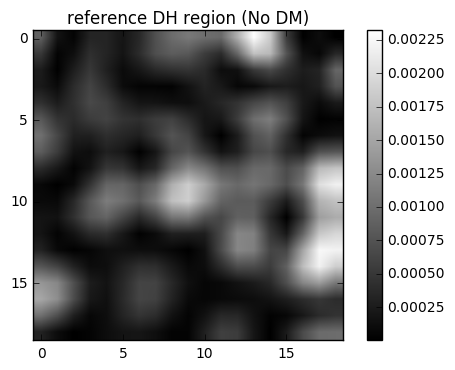

In [47]:
plt.imshow(ref_DH_region, cmap='gray')
plt.colorbar()
plt.title("reference DH region (No DM)")

In [1]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_sum_noDM,'bo-')
plt.plot()
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (sum), No DM',y=1.05)
plt.show()

NameError: name 'np' is not defined

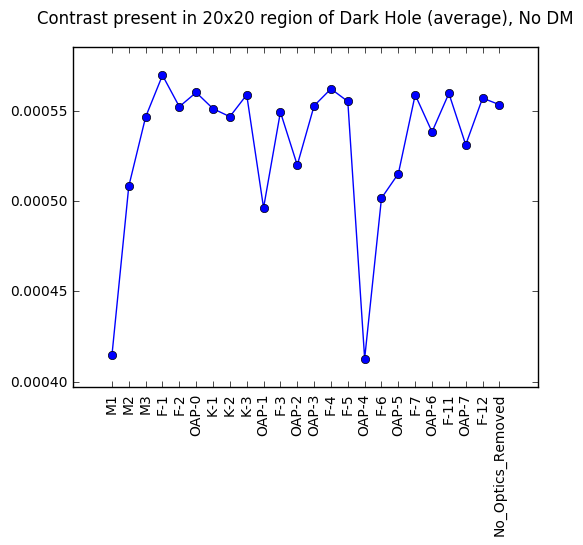

In [42]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_avg_noDM,'bo-')
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (average), No DM',y=1.05)
plt.show()

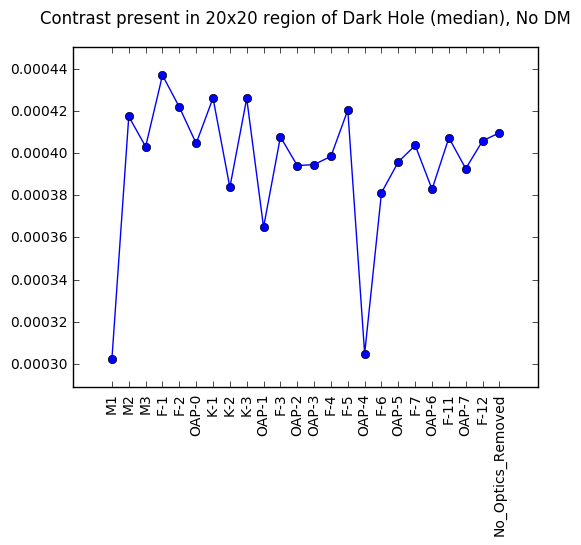

In [41]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_med_noDM,'bo-')
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (median), No DM',y=1.05)
plt.show()

# REFERENCE CODE BELOW
The reference code below only for show the loops implemented on each optical test.

# Version: With Lyot-Tweeter DM mapping

# Task 1: Lyot Plane Phase LPF Mapped to Tweeter
The goal of this task is to obtain the phase at the Lyot plane, perform a low pass filter, and create a surface map to send to the Tweeter DM. This will imply that the Tweeter DM only needs to correct the higher orders left from the incoming image.
## Part 1: Build to the Lyot Plane

In [7]:
telescope

[4, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 21, 22, 25, 26, 28, 30, 31, 32]

In [8]:
# Build the Lyot plane for each optical element surface removed
#for test_optic in mirrors_array:
for test_optic in telescope:
    
    print('Build FresnelOpticalSystem removing %s' % rx_sys['Name'][test_optic])
    
    print('Check original PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    hold_PSD = rx_sys['surf_PSD'][test_optic]
    print('Check hold_PSD: %s' % hold_PSD)
    rx_sys['surf_PSD'][test_optic] = 'none'
    print('Check removed PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    
    magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

    # Entrance Aperture
    magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

    # Build MagAO-X optical system from CSV file to the Lyot plane
    for n_optic,optic in enumerate(rx_sys): # n_optic: count, optic: value

        dz = optic['Distance_m'] * u.m # Propagation distance from the previous optic (n_optic-1)
        fl = optic['Focal_Length_m'] * u.m # Focal length of the current optic (n_optic)

        print('Check PSD file for %s: %s' % (optic['Name'], optic['surf_PSD']))
        # if PSD file present
        if optic['surf_PSD'] != 'none':
            # make a string insertion for the file location
            surf_file_loc = 'data/' + optic['surf_PSD'] + '.fits'
            # call surfFITS to send out surface map
            optic_surface = surfFITS(file_loc = surf_file_loc, optic_type = optic['optic_type'], 
                                     opdunit = optic['OPD_unit'], name = optic['Name']+' surface')
            # Add generated surface map to optical system
            magaox.add_optic(optic_surface,distance=dz)

            if fl != 0: # powered optic with PSD file present
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name'])) 
                # no distance; surface comes first
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

            elif optic['Type'] != 'pupil': # non-powered optic but has PSD present that is NOT the pupil
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

        # if no PSD file present (DM, focal plane, testing optical surface)
        else:
            # if powered optic is being tested
            if fl !=0: 
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name']), distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))
            
            # for DM, flat mirrors
            #elif optic['Type'] != 'fplane' and optic['Type'] != 'sci' and optic['Type'] != 'lyot': 
            elif optic['Type'] == 'mirror' or optic['Type'] == 'DM':
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))

            else: # for focal plane, science plane, lyot plane
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)

        # if the most recent optic studied was the Lyot plane, break out of loop.
        if optic['Type'] == 'lyot': 
            break
    
    # run the evaluation
    print('Build Lyot plane wavefront for %s' % rx_sys['Name'][test_optic])
    
    lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    
    lyot_num=len(lyot_wfs)-1 # last one will be the Lyot plane
    lyot_file_loc = 'data/lyot/lyotPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    lyot_wfs[lyot_num].asFITS('phase').writeto(lyot_file_loc)

    print('Finished writing Lyot plane wavefront for %s' % rx_sys['Name'][test_optic])
    
    rx_sys['surf_PSD'][test_optic] = hold_PSD
    print('Return original PSD for %s: %s'%(rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))

Build FresnelOpticalSystem removing F-1
Check original PSD for F-1: flat_l100_0
Check hold_PSD: flat_l100_0
Check removed PSD for F-1: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: none
Check PSD file for F11: none
Check PSD file for F-2: flat_l100_1
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Check PSD file for Tweeter: none
Check PSD file for OAP-3: oap_HP_3
Check PSD file for F-4: flat_l100_6
Check PSD file for F-5: flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: oap_HP_4
Check PSD file for F-6: flat_l100_8
Check PSD file for vAPP-trans: none
Check PSD f

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda

Finished writing Lyot plane wavefront for F-1
Return original PSD for F-1: flat_l100_0
Build FresnelOpticalSystem removing F-2
Check original PSD for F-2: flat_l100_1
Check hold_PSD: flat_l100_1
Check removed PSD for F-2: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: none
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Check PSD file for Tweeter: none
Check PSD file for OAP-3: oap_HP_3
Check PSD file for F-4: flat_l100_6
Check PSD file for F-5: flat_l100_7
Check PSD file for F57: none
Check PSD file for OAP-4: oap_H

## Part 2: Mapping Spatial Frequency
#### Calculate the sample frequencies along one axis in the FT Lyot Mask
The spatial frequency ranges will be the same for both axis.

In [10]:
#num_pix = FT_lyot.shape[0]
num_pix = 512 # hardcoded but that's what it is
sample_rate = (M1_radius.value*2)/num_pix
FT_lyot_freq = np.fft.fftfreq(num_pix,d=sample_rate)

Build Kx and Ky in Spatial Frequency domain.

Create spatial frequency magnitude map using:
$$ |K| = \sqrt{k_{x}^{2} + k_{y}^{2}}$$

In [ ]:
#num_pix = FT_lyot.shape[0]
DM_ctrl_BW = 24/(M1_radius.value*2)
num_pix = 512 # hardcoded but that's what it is
sample_rate = (M1_radius.value*2)/num_pix
FT_lyot_freq = np.fft.fftfreq(num_pix,d=sample_rate)
kx = np.resize(FT_lyot_freq,(FT_lyot_freq.size, FT_lyot_freq.size))

# Build ky the slow way
y_val=np.reshape(FT_lyot_freq,(FT_lyot_freq.size,1))
ky=y_val
for m in range (0,y_val.size-1):
    ky=np.hstack((ky,y_val))
    
magK = np.sqrt(kx*kx + ky*ky)

In [14]:
kx = np.resize(FT_lyot_freq,(FT_lyot_freq.size, FT_lyot_freq.size))

# Build ky the slow way
y_val=np.reshape(FT_lyot_freq,(FT_lyot_freq.size,1))
ky=y_val
for m in range (0,y_val.size-1):
    ky=np.hstack((ky,y_val))
    
magK = np.sqrt(kx*kx + ky*ky)
#plt.imshow(magK, cmap='gray')
#plt.colorbar()
#plt.title("magK")

#### Creating Spatial Frequency Filter
Calculate DM Control Bandwidth (hard value given by Jared)

In [15]:
DM_ctrl_BW = 24/(M1_radius.value*2)

## Part 3: Make DM surface map from Lyot Plane
#### Some notes:

#### Crop the Lyot data to a 512x512 image.

- Center pixel has half value in order to go an equal distance both directions for balanced image.
- The +1 in the high limit (h_lim) is included since python will stop at the last value but will not include it.

#### Where did the 0.0188 come from for PUPLSCAL?
- From PDR document (2.1, by Laird Close), the Tweeter DM is set to 19.2 x 18.8 mm with an indident angle at 11.716deg. The 19.2mm is from geometry for an elliptic beam whereas the 18.8mm is for a transmissive optic. So, I will use the 18.8mm diameter.

In [16]:
# Build the Lyot plane for each optical element surface removed
#for test_optic in mirrors_array:
for test_optic in telescope:
    # call in the Lyot Phase file
    lyot_file_loc = 'data/lyot/lyotPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    lyot_phase_data = fits.open(lyot_file_loc)[0].data
    
    # Crop Lyot 
    center_pix = 0.5*(lyot_phase_data.shape[0]-1)
    shift=255.5 # hardcoded, leave me alone
    h_lim = center_pix+shift
    l_lim = center_pix-shift
    lyot_phase = lyot_phase_data[l_lim:h_lim+1,l_lim:h_lim+1]
    
    # Multiply Lyot with pupil mask
    pupil_mask = fits.open('data/MagAOX_f11_pupil_512_unmasked.fits')[0].data
    lyot_mask = pupil_mask*lyot_phase
    
    # Take FT of Lyot
    FT_lyot = np.fft.fft2(lyot_mask)
    
    # LPF on FT_Lyot
    filter_lyot = np.zeros((512,512),dtype=np.complex128)
    for a in range (0,num_pix):
        for b in range (0,num_pix):
            #if (np.abs(kx[a][b]) < DM_ctrl_BW) and (np.abs(ky[a][b]) < DM_ctrl_BW): #square corner version
            if magK[a][b] < DM_ctrl_BW: # Curved corner version
                filter_lyot[a][b] = FT_lyot[a][b] # Keep FT value if less than DM BW
                
    # Post-LPF IFT
    lpf_lyot = np.fft.ifft2(filter_lyot)
    
    # Convert Phase to DM surface
    lpf_lyot_surf =(-1.0*testWavelength.value/(2*np.pi))*np.real(lpf_lyot) # FINAL!
    
    # Multiply by pupil mask to clean up ringing
    lpf_lyot_mask = pupil_mask*np.real(lpf_lyot_surf)
    
    # Write DM surface to file
    lyot_fits = fits.PrimaryHDU(data=lpf_lyot_mask)
    lyot_fits.header.set('PUPLSCAL', 0.0188/num_pix)
    lyot_fits.header.set('BUNIT', 'meters')
    lyot_surf_file_loc = 'data/DMsurf/DMsurf_check' + rx_sys['Name'][test_optic] + '.fits'
    lyot_fits.writeto(lyot_surf_file_loc)

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Task 2: Calculate to vAPP plane using Lyot Phase LPF on the Tweeter DM

In [20]:
# For sanity when re-running the loop
rx_sys=np.genfromtxt('data/rx_magaox.csv',delimiter=',', 
                  dtype="i2,U19,U10,f8,f8,f8,U90,U10,U10,f8,U10,",
                  skip_header=15,names=True)
print("the names of the headers are:")
print(rx_sys.dtype.names)

testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

M1_radius=rx_sys['Radius_m'][1]*u.m # Element [1] is M1 because Element [0] is the pupil mask
primary_fl=rx_sys['Focal_Length_m'][1]*u.m

for test_optic in telescope:
    
    print('Build FresnelOpticalSystem removing %s' % rx_sys['Name'][test_optic])
    
    print('Check original PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    hold_PSD = rx_sys['surf_PSD'][test_optic]
    print('Check hold_PSD: %s' % hold_PSD)
    rx_sys['surf_PSD'][test_optic] = 'none'
    print('Check removed PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    
    magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

    # Entrance Aperture
    magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

    # Build MagAO-X optical system from CSV file to the Lyot plane
    for n_optic,optic in enumerate(rx_sys): # n_optic: count, optic: value

        dz = optic['Distance_m'] * u.m # Propagation distance from the previous optic (n_optic-1)
        fl = optic['Focal_Length_m'] * u.m # Focal length of the current optic (n_optic)

        # If the current optic is at the Tweeter DM, add in the PSD surface.
        if optic['Name'] == 'Tweeter':
            DM_surf_loc = 'DMsurf/DMsurf_check' + rx_sys['Name'][test_optic]
            optic['surf_PSD'] = DM_surf_loc # this does not rewrite the CSV file.
            print('Inserting DM Surface generated for %s' % rx_sys['Name'][test_optic])

        print('Check PSD file for %s: %s' % (optic['Name'], optic['surf_PSD']))
        # if PSD file present
        if optic['surf_PSD'] != 'none':
            # make a string insertion for the file location
            surf_file_loc = 'data/' + optic['surf_PSD'] + '.fits'
            # call surfFITS to send out surface map
            optic_surface = surfFITS(file_loc = surf_file_loc, optic_type = optic['optic_type'], 
                                     opdunit = optic['OPD_unit'], name = optic['Name']+' surface')
            # Add generated surface map to optical system
            magaox.add_optic(optic_surface,distance=dz)

            if fl != 0: # powered optic with PSD file present
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name'])) 
                # no distance; surface comes first
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

            elif optic['Type'] != 'pupil': # non-powered optic but has PSD present that is NOT the pupil
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

        # if no PSD file present (DM, focal plane, testing optical surface)
        else:
            # if powered optic is being tested
            if fl !=0: 
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name']), distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))
            
            # for DM, flat mirrors
            #elif optic['Type'] != 'fplane' and optic['Type'] != 'sci' and optic['Type'] != 'lyot': 
            elif optic['Type'] == 'mirror' or optic['Type'] == 'DM':
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))

            else: # for focal plane, science plane, lyot plane
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)

        # if the most recent optic studied was the Lyot plane, break out of loop.
        if optic['Type'] == 'vapp': 
            break
    
    # run the evaluation
    print('Build vAPP plane wavefront for %s' % rx_sys['Name'][test_optic])
    
    vapp_psf, vapp_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    
    vapp_num=len(vapp_wfs)-1 # last one will be the vAPP plane
    vapp_phase_loc = 'data/vAPP_plane/vAPPPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wfs[vapp_num].asFITS('phase').writeto(vapp_phase_loc)
    vapp_complex_wf = vapp_wfs[vapp_num].asFITS('parts')
    vapp_wf_amp = fits.PrimaryHDU(data=vapp_complex_wf[0].data[0,:,:],header=vapp_complex_wf[0].header)
    vapp_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    vapp_amp_loc = 'data/vAPP_plane/vAPPPlane_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_wf_amp.writeto(vapp_amp_loc)

    print('Finished writing vapp plane wavefront for %s' % rx_sys['Name'][test_optic])
    
    rx_sys['surf_PSD'][test_optic] = hold_PSD
    print('Return original PSD for %s: %s'%(rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))

the names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')
Build FresnelOpticalSystem removing F-1
Check original PSD for F-1: flat_l100_0
Check hold_PSD: flat_l100_0
Check removed PSD for F-1: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: none
Check PSD file for F11: none
Check PSD file for F-2: flat_l100_1
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Inserting DM Surface generated for F-1
Check PSD file for Tweeter: DMsurf/DMsurf_checkF-1
Check PSD file 

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda

Finished writing vapp plane wavefront for F-1
Return original PSD for F-1: flat_l100_0
Build FresnelOpticalSystem removing F-2
Check original PSD for F-2: flat_l100_1
Check hold_PSD: flat_l100_1
Check removed PSD for F-2: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: none
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Inserting DM Surface generated for F-2
Check PSD file for Tweeter: DMsurf/DMsurf_checkF-2
Check PSD file for OAP-3: oap_HP_3
Check PSD file for F-4: flat_l100_6
Check PSD file for F-5: flat_l100_7
Che

# Task 3: Calculate vAPP Transmission/OPD Files
For every time a surface is removed, it will create a new DM surface from the Lyot plane LPF. So, the vAPP transmission and OPD files will be different despite the same vAPP baseline files.

In [21]:
vAPP_size = 512 # units: pixels
vAPP_diam = 0.009 # units: meters
vAPP_pixelscl = vAPP_diam/vAPP_size

vapp_phase_data = fits.open('data/coronagraph/MagAO-X_D_phase_512_pad1536.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAO-X_D_aperture_512_pad1536.fits')[0].data

header_holder = fits.getheader('data/coronagraph/MagAO-X_D_aperture_512_pad1536.fits')

# Build the Lyot plane for each optical element surface removed
#for test_optic in mirrors_array:
for test_optic in telescope:
    # call in the amplitude and phase files at vAPP plane
    vapp_phase_loc = 'data/vAPP_plane/vAPPPlane_Phase_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_amp_loc = 'data/vAPP_plane/vAPPPlane_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    vappPlane_phase_data = fits.open(vapp_phase_loc)[0].data
    vappPlane_amp_data = fits.open(vapp_amp_loc)[0].data
    
    # Generate OPD part of vAPP mask
    vapp_opd_data = (vappPlane_phase_data + vapp_phase_data) * vapp_aperture_data
    vapp_opd_surf_data = 1*(testWavelength.value/(2*np.pi))*vapp_opd_data
    vAPP_opd = fits.PrimaryHDU(data=vapp_opd_surf_data, header=header_holder)
    vAPP_opd.header.set('PUPLSCAL', vAPP_pixelscl)
    vAPP_opd.header.comments['PUPLSCAL'] = 'pixel scale [m/pix]'
    vAPP_opd.header.set('BUNIT', 'meters')
    vAPP_opd.header.comments['BUNIT'] = 'opd units'
    vaPP_opd_loc = 'data/vAPP_coronagraph/vAPP_OPD_check' + rx_sys['Name'][test_optic] + '.fits'
    vAPP_opd.writeto(vaPP_opd_loc)
    
    # Generate Tranmission part of vAPP mask
    vapp_trans_data = vappPlane_amp_data * vapp_aperture_data
    vapp_trans = fits.PrimaryHDU(data=vapp_trans_data, header=header_holder)
    vapp_trans.header.set('PUPLSCAL', vAPP_pixelscl)
    vapp_trans.header.comments['PUPLSCAL'] = 'pixel scale [m/pix]'
    vapp_trans_loc = 'data/vAPP_coronagraph/vAPP_trans_check' + rx_sys['Name'][test_optic] + '.fits'
    vapp_trans.writeto(vapp_trans_loc)


# Task 4: Get PSF for vAPP mask built with Lyot-Tweeter surface map.
The goal of this task is to see how the surface map on each optical element affects the Dark Hole (DH) in the Science PSF. This will be done by replacing the surface map with a "perfect" map (really, just removing the surface) and seeing how the flux in a small region of the DH will change. Each optical element with a surface will be evaluated to determine a list of offenders.

Each evaluation will include the Lyot Tweeter correction from Task 1 and the vAPP coronagraph.

In [30]:
# For sanity when re-running the loop
rx_sys=np.genfromtxt('data/rx_magaox.csv',delimiter=',', 
                  dtype="i2,U19,U10,f8,f8,f8,U90,U10,U10,f8,U10,",
                  skip_header=15,names=True)
print("the names of the headers are:")
print(rx_sys.dtype.names)

testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

M1_radius=rx_sys['Radius_m'][1]*u.m # Element [1] is M1 because Element [0] is the pupil mask
primary_fl=rx_sys['Focal_Length_m'][1]*u.m

for test_optic in telescope:
    
    print('Build FresnelOpticalSystem removing %s' % rx_sys['Name'][test_optic])
    
    print('Check original PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    hold_PSD = rx_sys['surf_PSD'][test_optic]
    print('Check hold_PSD: %s' % hold_PSD)
    rx_sys['surf_PSD'][test_optic] = 'none'
    print('Check removed PSD for %s: %s' % (rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))
    
    magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

    # Entrance Aperture
    magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

    # Build MagAO-X optical system from CSV file to the Science plane
    for n_optic,optic in enumerate(rx_sys): # n_optic: count, optic: value

        dz = optic['Distance_m'] * u.m # Propagation distance from the previous optic (n_optic-1)
        fl = optic['Focal_Length_m'] * u.m # Focal length of the current optic (n_optic)

        # If the current optic is at the Tweeter DM, add in the PSD surface.
        if optic['Name'] == 'Tweeter':
            DM_surf_loc = 'DMsurf/DMsurf_check' + rx_sys['Name'][test_optic]
            optic['surf_PSD'] = DM_surf_loc # this does not rewrite the CSV file.
            print('Inserting Surface generated for %s' % rx_sys['Name'][test_optic])
            
        elif optic['Name'] == 'vAPP-trans':
            vAPPtrans_loc = 'vAPP_coronagraph/vAPP_trans_check' + rx_sys['Name'][test_optic]
            optic['surf_PSD'] = vAPPtrans_loc # this does not rewrite the CSV file.
            print('Inserting Surface generated for %s' % rx_sys['Name'][test_optic])
            
        elif optic['Name'] == 'vAPP-opd':
            vAPP_OPD_surf_loc = 'vAPP_coronagraph/vAPP_OPD_check' + rx_sys['Name'][test_optic]
            optic['surf_PSD'] = vAPP_OPD_surf_loc # this does not rewrite the CSV file.
            print('Inserting Surface generated for %s' % rx_sys['Name'][test_optic])

        print('Check PSD file for %s: %s' % (optic['Name'], optic['surf_PSD']))
        # if PSD file present
        if optic['surf_PSD'] != 'none':
            # make a string insertion for the file location
            surf_file_loc = 'data/' + optic['surf_PSD'] + '.fits'
            # call surfFITS to send out surface map
            optic_surface = surfFITS(file_loc = surf_file_loc, optic_type = optic['optic_type'], 
                                     opdunit = optic['OPD_unit'], name = optic['Name']+' surface')
            # Add generated surface map to optical system
            magaox.add_optic(optic_surface,distance=dz)

            if fl != 0: # powered optic with PSD file present
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name'])) 
                # no distance; surface comes first
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

            elif optic['Type'] != 'pupil': # non-powered optic but has PSD present that is NOT the pupil
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m, 
                                                        name=optic['Name']+" aperture"))

        # if no PSD file present (DM, focal plane, testing optical surface)
        else:
            # if powered optic is being tested
            if fl !=0: 
                magaox.add_optic(poppy.QuadraticLens(fl,name=optic['Name']), distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))
            
            # for DM, flat mirrors
            #elif optic['Type'] != 'fplane' and optic['Type'] != 'sci' and optic['Type'] != 'lyot': 
            elif optic['Type'] == 'mirror' or optic['Type'] == 'DM':
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)
                magaox.add_optic(poppy.CircularAperture(radius=optic['Radius_m']*u.m,
                                                        name=optic['Name']+" aperture"))

            else: # for focal plane, science plane, lyot plane
                magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                         name=optic['Name']),distance=dz)
    
    # run the evaluation
    print('Build science PSF plane wavefront with DM, VAPP for %s' % rx_sys['Name'][test_optic])
    
    sci_psf, sci_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    
    sci_num=len(sci_wfs)-1 # last one will be the F/69 Science plane
    sci_intensity = sci_wfs[sci_num].asFITS('intensity')
    sci_intensity_loc = 'output/DM_vAPP_SciPSF/SciPSF_intensity_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_intensity.writeto(sci_intensity_loc)
    sci_phase_loc = 'output/DM_vAPP_SciPSF/SciPSF_phase_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wfs[sci_num].asFITS('phase').writeto(sci_phase_loc)
    sci_complex_wf = sci_wfs[sci_num].asFITS('parts')
    sci_wf_amp = fits.PrimaryHDU(data=sci_complex_wf[0].data[0,:,:],header=sci_complex_wf[0].header)
    sci_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
    sci_amp_loc = 'output/DM_vAPP_SciPSF/SciPSF_Amplitude_check' + rx_sys['Name'][test_optic] + '.fits'
    sci_wf_amp.writeto(sci_amp_loc)

    print('Finished writing science PSF, phase, amplitude for %s' % rx_sys['Name'][test_optic])
    
    rx_sys['surf_PSD'][test_optic] = hold_PSD
    print('Return original PSD for %s: %s'%(rx_sys['Name'][test_optic], rx_sys['surf_PSD'][test_optic]))

the names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')
Build FresnelOpticalSystem removing F-1
Check original PSD for F-1: flat_l100_0
Check hold_PSD: flat_l100_0
Check removed PSD for F-1: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: none
Check PSD file for F11: none
Check PSD file for F-2: flat_l100_1
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Inserting Surface generated for F-1
Check PSD file for Tweeter: DMsurf/DMsurf_checkF-1
Check PSD file for

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda

Finished writing science PSF, phase, amplitude for F-1
Return original PSD for F-1: flat_l100_0
Build FresnelOpticalSystem removing F-2
Check original PSD for F-2: flat_l100_1
Check hold_PSD: flat_l100_1
Check removed PSD for F-2: none
Check PSD file for pupil: MagAOX_f11_pupil_256_unmasked
Check PSD file for M1: ClayM1_0mask_meters_new
Check PSD file for M2: M2_fitpsd
Check PSD file for M3: M3_fitpsd
Check PSD file for F-1: flat_l100_0
Check PSD file for F11: none
Check PSD file for F-2: none
Check PSD file for OAP-0: oap_HP_0
Check PSD file for K-1: flat_l100_2
Check PSD file for K-2: flat_l100_3
Check PSD file for K-3: flat_l100_4
Check PSD file for Woofer: none
Check PSD file for OAP-1: oap_HP_1
Check PSD file for F-3: flat_l100_5
Check PSD file for F16: none
Check PSD file for OAP-2: oap_HP_2
Inserting Surface generated for F-2
Check PSD file for Tweeter: DMsurf/DMsurf_checkF-2
Check PSD file for OAP-3: oap_HP_3
Check PSD file for F-4: flat_l100_6
Check PSD file for F-5: flat_l100

# Task 5: Check flux in small region of dark hole
The goal of this task is to see how the surface map on each optical element affects the Dark Hole (DH) in the Science PSF. This will be done by replacing the surface map with a "perfect" map (really, just removing the surface) and seeing how the flux in a small region of the DH will change. Each optical element with a surface will be evaluated to determine a list of offenders.

Each evaluation will include the Lyot Tweeter correction from Task 1 and the vAPP coronagraph.

In [21]:
# initiate flux dictionary and arrays
flux_sum_withDM = []
flux_avg_withDM = []
flux_med_withDM = []
optics_names = []

# pre-calculate the ranges
center_pix = [767.5, 747.5] # changed for 20x20 size region
shift=9.5 # hardcoded for 20x20 size region
h_lim = [x+shift for x in center_pix]
l_lim = [x-shift for x in center_pix]

telescope = mirrors_array

for test_optic in telescope:
    # call in the science plane intensity file
    sciPSF_file_loc = 'output/DM_vAPP_SciPSF/SciPSF_intensity_check' + rx_sys['Name'][test_optic] + '.fits'
    sciPSF_data = fits.open(sciPSF_file_loc)[0].data
    
    # find brightest pixel in the whole image
    peak_value = np.amax(np.amax(sciPSF_data))
    
    # contrast the full image
    contrast_image = sciPSF_data/peak_value
    
    # Crop to 10x10 region inside dark hole
    DH_region = contrast_image[l_lim[0]:h_lim[0],l_lim[1]:h_lim[1]]
    
    # Sum together the values for the flux in the region
    DH_region_sum = np.sum(np.sum(DH_region))
    DH_region_avg = np.mean(DH_region)
    DH_region_med = np.median(DH_region)
    
    # Add to dictionary and lists
    flux_sum_withDM.append(DH_region_sum)
    flux_avg_withDM.append(DH_region_avg)
    flux_med_withDM.append(DH_region_med)
    optics_names.append(rx_sys['Name'][test_optic])

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Calculate Dark Hole reference. The reference is where no optics have been removed.

In [44]:
# call in the science plane intensity file
ref_sciPSF_file_loc = 'output/F69Sci_WithAberration_unmaskedPupil_LyotTweeter_vAPP_Intensity.fits'
ref_sciPSF_data = fits.open(ref_sciPSF_file_loc)[0].data

# calculate the peak value of whole image
ref_peak = np.amax(np.amax(ref_sciPSF_data))

# Crop to 10x10 region inside dark hole
ref_DH_region = ref_sciPSF_data[l_lim[0]:h_lim[0],l_lim[1]:h_lim[1]]
ref_DH_region = ref_DH_region/ref_peak

# Sum together the values for the flux in the region
ref_DH_region_sum = np.sum(np.sum(ref_DH_region))
ref_DH_region_avg = np.mean(ref_DH_region)
ref_DH_region_med = np.median(ref_DH_region)

# add in the pre-calculated no-optics version to the whole list
flux_sum_withDM.append(ref_DH_region_sum)
flux_avg_withDM.append(ref_DH_region_avg)
flux_med_withDM.append(ref_DH_region_med)
optics_names.append('No_Optics_Removed')

/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [23]:
ref_DH_region_sum

0.037426498470890295

In [24]:
ref_DH_region_avg

0.00010367451099969611

In [26]:
ref_DH_region_med

7.2783472537990939e-05

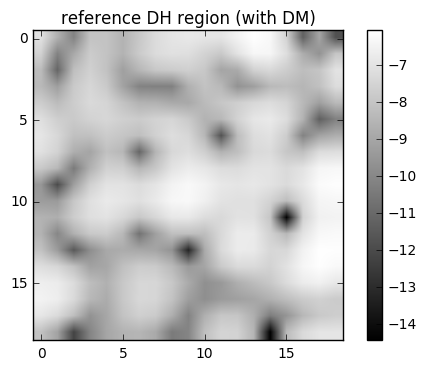

In [48]:
plt.imshow(np.log(ref_DH_region), cmap='gray')
plt.colorbar()
plt.title("reference DH region (with DM)")

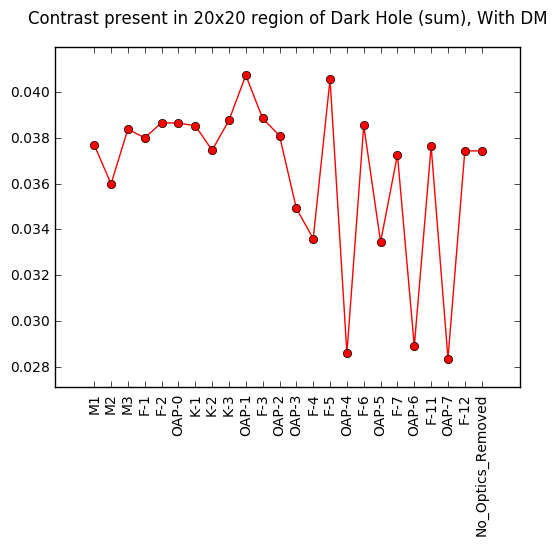

In [35]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_sum_withDM,'ro-')
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (sum), With DM',y=1.05)
plt.show()

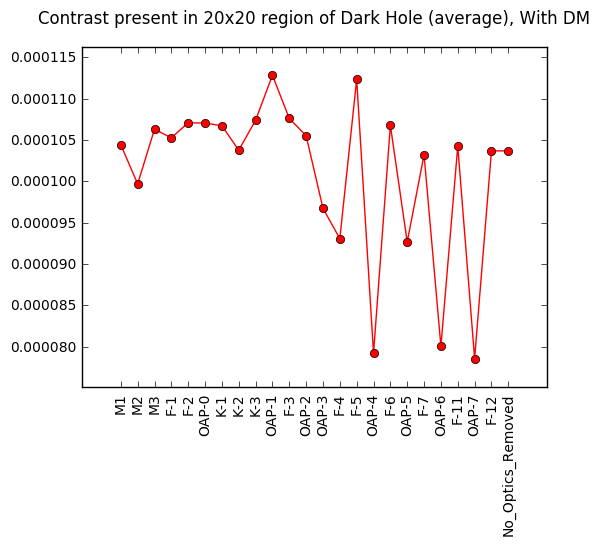

In [38]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_avg_withDM,'ro-')
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (average), With DM',y=1.05)
plt.show()

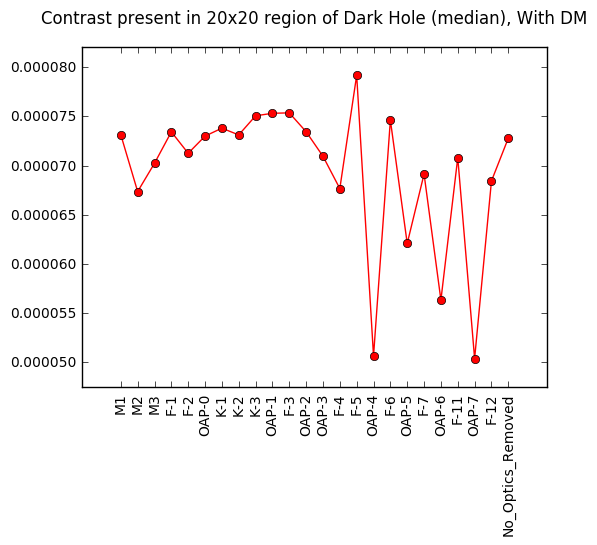

In [40]:
x=np.arange(len(mirrors_array)+1)
plt.plot(x,flux_med_withDM,'ro-')
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Contrast present in 20x20 region of Dark Hole (median), With DM',y=1.05)
plt.show()

Current evaluation: This looks weird. The next attempt will be without the Lyot-Tweeter DM correction.